![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 07 - PyTorch 2 </center>
### <center> TensorBoard </center>

Colab users should use GPU runtime:  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch2/MainPyTorchTensorBoard.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

import torch.nn          as nn
import torch.optim       as optim
import torchinfo

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed   (0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/07_PyTorch2/DeepLearningFramework ./DeepLearningFramework
    !pip install tensorboard

### Load Fashion-MNIST data:

In [5]:
import torchvision
import torchvision.transforms as transforms

oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(0.5, 0.5)
])

DATA_PATH = '../../data'
oTrainSet = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=False, transform=oTransform)

oTrainDL  = torch.utils.data.DataLoader(oTrainSet, batch_size=1024, shuffle=True,  num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  batch_size=1024, shuffle=False, num_workers=2, persistent_workers=True)

lClasses  = oTrainSet.classes
mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([1024, 1, 28, 28])

#### Plot some examples:

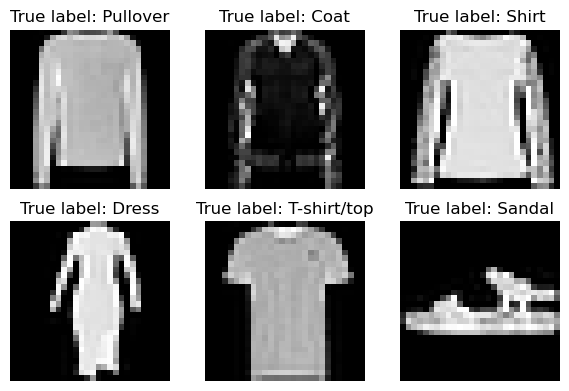

In [6]:
def Unnormalize(mX):
    return 1/2 * mX + 1/2

N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(6, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mXi, y = oTrainSet[idx]
    mXi    = Unnormalize(mXi[0])
    mXi    = torch.clamp(mXi, 0, 1)
    ax.imshow   (mXi, cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show        ()

#### Define a model:

In [7]:
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(1,  8,   9), nn.LeakyReLU(),
        nn.Conv2d(8,  16,  7), nn.LeakyReLU(),
        nn.Conv2d(16, 32,  5), nn.LeakyReLU(),
        nn.Conv2d(32, 64,  5), nn.LeakyReLU(),
        nn.Conv2d(64, 128, 5), nn.LeakyReLU(),
        
        nn.Flatten(),
        nn.Linear (512, 10)
    )
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [1024, 1, 28, 28]         --
├─Conv2d: 1-2                            [1024, 8, 20, 20]         656
├─LeakyReLU: 1-3                         [1024, 8, 20, 20]         --
├─Conv2d: 1-4                            [1024, 16, 14, 14]        6,288
├─LeakyReLU: 1-5                         [1024, 16, 14, 14]        --
├─Conv2d: 1-6                            [1024, 32, 10, 10]        12,832
├─LeakyReLU: 1-7                         [1024, 32, 10, 10]        --
├─Conv2d: 1-8                            [1024, 64, 6, 6]          51,264
├─LeakyReLU: 1-9                         [1024, 64, 6, 6]          --
├─Conv2d: 1-10                           [1024, 128, 2, 2]         204,928
├─LeakyReLU: 1-11                        [1024, 128, 2, 2]         --
├─Flatten: 1-12                          [1024, 512]               -

### TensorBoard:
https://www.tensorflow.org/tensorboard/get_started

You can also check the official tutorial (but with `tensorflow`):  
https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb

In [8]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is `runs`
oWriter = SummaryWriter('runs/Run1')

In [9]:
if 'google.colab' in str(get_ipython()):
    #-- https://github.com/pytorch/pytorch/issues/30966
    import tensorflow as tf
    import tensorboard as tb
    tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
    #--
    %load_ext tensorboard
    %tensorboard --logdir=runs

cmd (from the same path as this file):  
`tensorboard --logdir=runs`  
go to:  
http://localhost:6006/

#### Write images to TensorBoard:

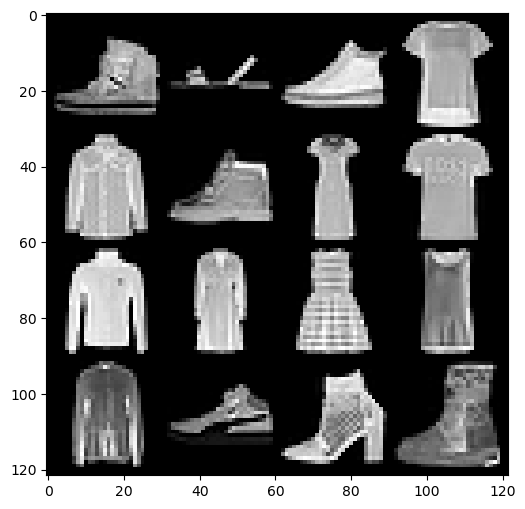

In [10]:
mX          = Unnormalize(next(iter(oTrainDL))[0][:16])
mImagesGrid = torchvision.utils.make_grid(mX, nrow=4)   #-- 4 x 4 grid

#-- write to tensorboard
oWriter.add_image('Training images', mImagesGrid)
# oWriter.close()

plt.figure(figsize=(8, 6))
plt.imshow(mImagesGrid.permute(1,2,0))
plt.show()

#### Write model's graph to TensorBoard:

In [11]:
oModel = GetModel()
oWriter.add_graph(oModel, mX)

#### Add embeddings to TensorBoard:
if data do not apper in TensorBoard, reconnect in the cmd.

In [12]:
#-- A way to get N (random) data points:
N         = 1000
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, batch_size=N, shuffle=True)
mX, vY    = next(iter(oTrainDL2))
lLabels   = [lClasses[y] for y in vY]

#-- Add embeddings to TensorBoard:
mFeatures = mX.view(N, -1)
oWriter.add_embedding(mFeatures, metadata=lLabels, label_img=1-Unnormalize(mX), tag='Raw data')

#### A function to plot a sample with its label prediction:

In [13]:
def PlotImages(oModel, mX, vY):
    N     = mX.shape[0]
    mP    = torch.softmax(oModel(mX), dim=1)
    vHatY = torch.argmax(mP, dim=1)
    vP    = mP[range(N),vHatY]
    
    fig, _ = plt.subplots(2, 4, figsize=(12, 8))
    for ii, ax in enumerate(fig.axes):
        if vHatY[ii] == vY[ii]:
            color = 'g'
        else:
            color = 'r'
        
        label     = lClasses[vY[ii]]
        labelHat  = lClasses[vHatY[ii]]
        ax.imshow(mX[ii].squeeze().cpu() * 0.5 + 0.5, cmap='gray')        
        ax.set_title(f'{labelHat}, {100 * vP[ii]:.1f}%\n'
                     f'(True label: {label})', color=color)
        plt.tight_layout()
    return fig

In [14]:
class Logger:
    def __init__(self, sName):
        self.oWriter = SummaryWriter(sName)
        self.iter    = 0
        self.epoch   = 0

In [15]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True, oLogger=None):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)
            loss = Loss(mZ, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

        #=======================================================================================#
        if bTrain == True:
            oLogger.oWriter.add_scalar ('Learning rate',    vLR[ii],                global_step=oLogger.iter)
            oLogger.oWriter.add_scalars('Loss (per batch)', {'Train': loss.item()}, global_step=oLogger.iter)
            oLogger.iter += 1
        #=======================================================================================#

    #===============================================================================#
    if bTrain == True:
        oLogger.oWriter.add_scalars('Loss (per epoch)', {'Train':      loss.item()}, global_step=oLogger.epoch)
    else:
        oLogger.oWriter.add_scalars('Loss (per epoch)', {'Validation': loss.item()}, global_step=oLogger.epoch)
        oLogger.oWriter.add_figure('Accuracy',          PlotImages(oModel, mX, vY),  global_step=oLogger.epoch)
        oLogger.epoch += 1
    oWriter.flush()
    #===============================================================================#
    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [16]:
import time
from DeepLearningFramework.Metric import Accuracy

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim, oScheduler=None, oLogger=None):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    vLR        = np.full(0,       np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime                 = time.time()
        trainLoss, trainAcc, vLRi = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, oScheduler, bTrain=True,  oLogger=oLogger) #-- train
        valLoss,   valAcc,   _    = Epoch(oModel, oValData,   Loss, Accuracy,                     bTrain=False, oLogger=oLogger) #-- validate
        epochTime                 = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}',   end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        vLR               = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR

#### Device:

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [18]:
nEpochs = 10
oLogger = Logger('runs/SimpleRun')

Loss    = nn.CrossEntropyLoss()
oModel  = GetModel().to(DEVICE)
oOptim  = optim.SGD(oModel.parameters(), lr=1e-2, momentum=.5)
TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oLogger=oLogger);
oLogger.oWriter.close()

Epoch 000: | Train loss:  2.301 | Val loss:  2.299 | Train Accuracy:  0.104 | Val Accuracy:  0.138 | epoch time:  6.378 | <-- Checkpoint!
Epoch 001: | Train loss:  2.290 | Val loss:  2.267 | Train Accuracy:  0.223 | Val Accuracy:  0.273 | epoch time:  4.584 | <-- Checkpoint!
Epoch 002: | Train loss:  1.903 | Val loss:  1.452 | Train Accuracy:  0.296 | Val Accuracy:  0.443 | epoch time:  4.535 | <-- Checkpoint!
Epoch 003: | Train loss:  1.282 | Val loss:  1.058 | Train Accuracy:  0.516 | Val Accuracy:  0.620 | epoch time:  4.483 | <-- Checkpoint!
Epoch 004: | Train loss:  0.973 | Val loss:  1.026 | Train Accuracy:  0.639 | Val Accuracy:  0.614 | epoch time:  4.659 |
Epoch 005: | Train loss:  0.847 | Val loss:  0.821 | Train Accuracy:  0.681 | Val Accuracy:  0.684 | epoch time:  4.457 | <-- Checkpoint!
Epoch 006: | Train loss:  0.758 | Val loss:  0.766 | Train Accuracy:  0.712 | Val Accuracy:  0.706 | epoch time:  4.422 | <-- Checkpoint!
Epoch 007: | Train loss:  0.719 | Val loss:  0.756

In [19]:
from torch.optim import lr_scheduler

nEpochs = 10
nIter   = nEpochs * len(oTrainDL)

lScheduler   = []
lScheduler  += [('Exp',      lr_scheduler.ExponentialLR,     {'gamma'  :0.995})]
lScheduler  += [('Cos',      lr_scheduler.CosineAnnealingLR, {'T_max'  :nIter})]
lScheduler  += [('Cyclic',   lr_scheduler.CyclicLR,          {'base_lr':1e-4, 'max_lr':1e-2, 'step_size_up':nIter//6, 'step_size_down':nIter//6, 'mode':'triangular2', 'cycle_momentum':False})]
lScheduler  += [('OneCycle', lr_scheduler.OneCycleLR,        {'max_lr' :1e-2, 'total_steps':nIter})]

In [20]:
for (name, Scheduler, dArgs) in lScheduler:
    print( '===============================================================')
    print(f'Train configuration: {name}')
    print( '===============================================================')
    oLogger    = Logger(f'runs/Configuration_{name}')
    oModel     = GetModel().to(DEVICE)
    oOptim     = optim.AdamW(oModel.parameters(), lr=1e-2, betas=(0.9, 0.99), weight_decay=1e-4)
    oScheduler = Scheduler(oOptim, **dArgs)
    TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler, oLogger);
    oLogger.oWriter.close()

Train configuration: Exp
Epoch 000: | Train loss:  2.076 | Val loss:  1.178 | Train Accuracy:  0.327 | Val Accuracy:  0.559 | epoch time:  4.466 | <-- Checkpoint!
Epoch 001: | Train loss:  0.970 | Val loss:  0.838 | Train Accuracy:  0.629 | Val Accuracy:  0.686 | epoch time:  4.431 | <-- Checkpoint!
Epoch 002: | Train loss:  0.773 | Val loss:  0.748 | Train Accuracy:  0.707 | Val Accuracy:  0.711 | epoch time:  4.478 | <-- Checkpoint!
Epoch 003: | Train loss:  0.687 | Val loss:  0.674 | Train Accuracy:  0.737 | Val Accuracy:  0.741 | epoch time:  4.627 | <-- Checkpoint!
Epoch 004: | Train loss:  0.616 | Val loss:  0.632 | Train Accuracy:  0.763 | Val Accuracy:  0.758 | epoch time:  4.655 | <-- Checkpoint!
Epoch 005: | Train loss:  0.584 | Val loss:  0.606 | Train Accuracy:  0.776 | Val Accuracy:  0.766 | epoch time:  4.493 | <-- Checkpoint!
Epoch 006: | Train loss:  0.558 | Val loss:  0.576 | Train Accuracy:  0.786 | Val Accuracy:  0.781 | epoch time:  4.471 | <-- Checkpoint!
Epoch 007

### Exercise
Add train and validation accuracy to `tensorboard`.

In [21]:
???

Object `?` not found.
